In [1]:
push!(LOAD_PATH,pwd())
using ProfileView
using constants
using types10
using Optim
using PyPlot
using dataPS
include("DOSfunctions.jl")
include("userfunctions.jl")
include("propertyfuncs.jl")

kltSA (generic function with 1 method)

In [2]:
Eoff=5.0
Ts=collect(300.0:10.0:900.0)
######################################################################################
##for Liu x=0.6 best fit x=0.635 N=-1.45e20
######################################################################################
numofn=[7.0e18]#,-1.22e18,-1.02e18,-0.94e18]#-9.5e19,-1.75e20,-3.0e19,-0.9e20]#Sample 1 -3.0e19, Sample 2 -1.25e20,
numofnn=[1e17]#,1e18,1e18,1e18]
#Sample 3 -1.75e20, Sample Sb 0.75% -1.03e20, #
xs=[0.6]#,0.8,0.7,0.61]#collect(0.0:0.01:1.0)
Es=collect(0.0:0.1:3.0)

var0=[Ts[1],xs[1]]

EX3(var)=Eoff#+Egx3(var[1],var[2])
EX1(var)=Ec0(var[2])+EX3(var)
ELH(var)=Eoff-Egx3(var[1],var[2])
EHH(var)=Eoff-Egx3(var[1],var[2])
Ecutoff=0.1
effMassX1(var)=X1effMass(var[1])*me
effMassX3(var)=0.38*me
effMassLH(var)=-1.0*me
effMassHH(var)=-1.5*me

alphaX1(var)=0.0#EX1(var0)
alphaX3(var)=0.0#EX1(var0)
alphaLH(var)=0.0#EX3(var0)
alphaHH(var)=0.0#EX3(var0)

function Da(band::parBandTxC,x::Float64)
    Da=7.0#9.0-1.5*x*x
    Dv=1.0
    if band==bandX3 ||  band==bandX1
        return Da
    end
    if band==bandHH ||  band==bandLH
        return Dv
    end
end

bandX3=parBandTxC(true,1.0,effMassX3(var0),alphaX3(0.0),EX3(var0),0.0,[EX3],[effMassX3],[alphaX3],var0)
bandX1=parBandTxC(true,1.0,effMassX1(var0),alphaX1(0.0),EX1(var0),0.0,[EX1],[effMassX1],[alphaX1],var0)
bandHH=parBandTxC(true,1.0,effMassHH(var0),alphaHH(0.0),EHH(var0),Ecutoff,[EHH],[effMassHH],[alphaHH],var0)
bandLH=parBandTxC(true,1.0,effMassLH(var0),alphaLH(0.0),ELH(var0),Ecutoff,[ELH],[effMassLH],[alphaLH],var0)
bndstTx=BandStrucTx([bandLH,bandHH,bandX1,bandX1,bandX1,bandX3,bandX3,bandX3],var0)#
#bndstTx=BandStrucTx([bandLH,bandX1],var0)#

#vartau0=[bandC.effMass,Ts[1],Ec(var0),xs[1],Ec(var0),bandC,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandV]
vartau0=[bandX3.effMass,Ts[1],EX1(var0),xs[1],EX1(var0),bandX3,numofn[1]*1e6,bndstTx,numofnn[1]*1e6,bandLH]
#var array: var[1]: effMass , var[2]:T, var[3]:E, var[4]:x, var[5]:Ef, 
#var[6]:band, var[7]:NII var[8]:bndst
#tauAC(var)=tauAC_func(Cl(var[4]),acPhDa(var[4]),var[2],var[1],var[3],var[6])
tauAC(var)=tauAC_func(Cl(var[4]),Da(var[6],var[4]),var[2],var[1],var[3],var[6])
tauPOP(var)=tauPOP_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1]
,var[3],tauPOPIIint(var[5],var[2],var[4],var[6]),var[7],opPhE(var[4]),var[8])
tauPOP2(var)=tauPOP2lowN_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauPOP3(var)=tauPOP3_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[1],
var[3],opPhE(var[4]))
tauII2(var)=tauII2_func(epsilon0_x(var[4]),epsilonhf_x(var[4]),var[6],var[5],var[2],var[7],var[1],var[3],var[8])
tauNI(var)=tauNI_func(epsilon0_x(var[4]),var[1],var[9])
tauTOTTx=tau_electron_B([tauAC,tauII2,tauNI,tauPOP3],vartau0)#,tauII2,tauPOP2,tauPOP3

xmax=3.0

3.0

In [3]:
@time (Efs,sigmas,seebecks,kes,kees,kehs,kbis,sigmaes,sigmahs,seebeckes,seebeckhs)=electronicPropsiso(bndstTx,xs,Ts,numofn,numofnn,tauTOTTx,xmax)
x=3.0

 45.586976 seconds (233.85 M allocations: 43.046 GiB, 12.58% gc time)


3.0

In [4]:
T_EF_Dict=Dict()
for (Ti,Tx) in enumerate(Ts)
    T_EF_Dict[Tx]=(Efs[Ti])    
end
T_EF_Dict_Array=Array{Dict{Float64,Float64},2}(undef,length(numofn),length(xs))
Dict_temp=Dict()
Efsr=Array{Float64,3}(undef,length(Ts),length(numofn),length(xs))
for (j,jn) in enumerate(numofn)
    for (k,kx) in enumerate(xs) 
        for (i,iT) in enumerate(Ts)
            Efsr[i,j,k]=Efs[i,j,k]-EX3(0.0)
            Dict_temp[iT]=Efsr[i,j,k]
            T_EF_Dict_Array[j,k]=Dict_temp 
        end
    end
end
#foreach(i->println("$i= ",Ts[i]),1:length(Ts))
#Efsr

In [5]:
#println("-1")
#############Lattice Thermal Conductivity Parameters###############
function klpar(con::Float64,p::Float64,NP::Float64)
    thetaL=52.3e12*hbar/kB # K 
    thetaT=29.7e12*hbar/kB  # K
    vL=(1-con)*7700+con*4900    # m/s
    vT=(1-con)*4900+con*3000    # m/s
    gammaL=2.5*(1-con)+1.7*con
    gammaT=2.5*(1-con)+1.7*con
    M=(2*(24.305e-3)+(28.0855e-3*(1-con)+118.71e-3*con))/3/Nav
    V=((1-con)*(6.39e-10)^3+con*(6.77e-10)^3)/12
    a=V^(1.0/3.0)
    ro=M/V
    Vdj=(((6.39e-10)^3)/((1-con)*(6.39e-10)^3+con*(6.77e-10)^3))^(1/3)
    jL=vL/7700*Vdj
    jT=vT/4900*Vdj
    thetaLx=thetaL*jL
    thetaTx=thetaT*jT
    ##########Boundary Scattering###############3
    D=11e-9
    p=0.65
    ##########Alloy Scattering###################
    mbar=(28.0855*(1-con)+118.71*con)
    GammaSiSn=(1-con)*((28.0855-mbar)/mbar)^2+con*((118.71-mbar)/mbar)^2
    GammaMgSiSn=2*((mbar/(24.305+mbar))^2*GammaSiSn);         
    ##########Electron Scattering###################
    Ehp=1.0*q
    Eep=5.0*q
    xsp=xs[1]
    Tp=300.0
    mdx1=0.67*me
    mdx3=0.38*me
    mdLH=1.0*me
    mdHH=1.2*me
    Efx3=0.2589
    Efx1=0.2589
    ##########Nanoparticle Scattering###################
    #NP=0
    #alpha=1.0
    Rnp=5.0e-9#
    Vnp=4/3*pi*(Rnp)^3
    rhonp=NP/100/Vnp
    rhoM=3.0
    rhoT=3.78
    alphaNP=0.2289#1-exp(-1*(rhoT-rhoM)/rhoM);
#vartauPH0=[[0.02],Ts[1],gammaL,gammaT,xsp,thetaCLx,thetaCTx,thetaCTx,MSi,MGe,VSi,a,T_EF_Dict,0.0]
    Tsindex=1#25
    numberofnindex=1
    xsindex=1
    vartauPH0=[ [0.02],  Ts[1],   gammaL,  gammaT, con,#5
        thetaLx, thetaTx, thetaTx, M,   M, #10
        V, a, T_EF_Dict_Array, Eep, alphaNP, #15
        Rnp, thetaLx, thetaTx, vL, vT, #20
        vL, vT, p, NP,Tsindex,#25
        numberofnindex,xsindex,p,D,GammaMgSiSn,#30
        mdx1,mdx3,Efx1,Efx3,ro,#35,
        NP,alphaNP,Rnp,Vnp,rhonp, #40
        Ehp,mdHH,mdLH
        ]  
    thetaCLx=thetaCL(vartauPH0[12],vartauPH0[5],vartauPH0[17],vartauPH0[19],vartauPH0[11])
    thetaCTx=thetaCT(vartauPH0[12],vartauPH0[5],vartauPH0[18],vartauPH0[19],vartauPH0[11])
    #println("2")
    tauPHNLf(var)=tauPH_NL(var[3],var[11],var[1],var[2],var[9],var[21])
    tauPHNTf(var)=tauPH_NT(var[4],var[11],var[1],var[2],var[9],var[22]) 

    tauPHULf(var)=tauPH_U(var[3],var[1],var[2],var[9],var[19],var[17])
    tauPHUTf(var)=tauPH_U(var[4],var[1],var[2],var[9],var[20],var[18])

    tauPHALLLf(var)=tauPH_ALL(var[30],var[11],var[1],var[2],var[19])
    tauPHALLTf(var)=tauPH_ALL(var[30],var[11],var[1],var[2],var[20])
   
    tauPHeLfLH(var)=tauPH_e(var[41],var[43],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfLH(var)=tauPH_e(var[41],var[43],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])

    tauPHeLfHH(var)=tauPH_e(var[41],var[42],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfHH(var)=tauPH_e(var[41],var[42],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])


    tauPHeLfX3(var)=tauPH_e(var[14],var[32],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[21])
    tauPHeTfX3(var)=tauPH_e(var[14],var[32],var[35],(var[13][var[26],var[27]])[var[2]],var[1],var[2],var[22])

    tauPHeLfX1(var)=tauPH_e(var[14],X1effMass(var[2])*me,var[35],(var[13][var[26],var[27]])[var[2]]-Ec0(0.6)
        ,var[1],var[2],var[21])
    tauPHeTfX1(var)=tauPH_e(var[14],X1effMass(var[2])*me,var[35],(var[13][var[26],var[27]])[var[2]]-Ec0(0.6)
        ,var[1],var[2],var[22])

    tauPHBLf(var)=tauPH_B(var[19],var[28],var[29])
    tauPHBTf(var)=tauPH_B(var[20],var[28],var[29])
    #println("3")

    tauPHNPLf(var)=tauPH_NP(var[37],var[40],var[38],var[1],var[2],var[19])
    tauPHNPTf(var)=tauPH_NP(var[37],var[40],var[38],var[1],var[2],var[20])

    tauPHTOTL=tau_phonon_B([tauPHNLf,tauPHULf,tauPHBLf,tauPHALLLf,tauPHeLfLH,tauPHeLfHH,tauPHNPLf],vartauPH0)#,tauPHNPLf,tauPHALLLf,tauPHeLf,tauPH_eLf ,tauPHALLLf ,tauPHBLf,,tauPHULf
    tauPHNL=tau_phonon_B([tauPHNLf],vartauPH0) #tauPHeLfX3,tauPHeLfX1
    tauPHRL=tau_phonon_B([tauPHULf,tauPHBLf,tauPHALLLf,tauPHeLfLH,tauPHeLfHH,tauPHNPLf],vartauPH0) #,tauPHNPLf,tauPHALLLf,tauPHeLf,tauPHALLLf,tauPH_eLf] ,tauPHBLf

    tauPHTOTTx=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHALLTf,tauPHeTfLH,tauPHeTfHH,tauPHBTf,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf ,tauPHBTf
    tauPHNTx=tau_phonon_B([tauPHNTf],vartauPH0)
    tauPHRTx=tau_phonon_B([tauPHUTf,tauPHALLTf,tauPHeTfLH,tauPHeTfHH,tauPHBTf,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf ,tauPHBTf#

    tauPHTOTTy=tau_phonon_B([tauPHNTf,tauPHUTf,tauPHBTf,tauPHALLTf,tauPHeTfHH,tauPHeTfLH,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPHeTf,tauPHALLTf,tauPH_eTf tauPHBTf
    tauPHNTy=tau_phonon_B([tauPHNTf],vartauPH0)
    tauPHRTy=tau_phonon_B([tauPHUTf,tauPHBTf,tauPHALLTf,tauPHeTfHH,tauPHeTfLH,tauPHNPTf],vartauPH0) #,tauPHNPTf,tauPHALLTf,tauPH_eTf ,tauPHBTf,tauPHALLTf,tauPHeTf
    #println("4")
    tauPHL=[tauPHTOTL,tauPHNL,tauPHRL]
    tauPHTx=[tauPHTOTTx,tauPHNTx,tauPHRTx]
    tauPHTy=[tauPHTOTTx,tauPHNTx,tauPHRTx]
    return (vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)
end
xmax=1.0

1.0

In [6]:
NPx=5.0
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,
    tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(0.6,0.65,NPx)
klsM=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,klsM[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,
        tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
    #println("T=", iTx, " kl= " ,round(klsM[iT,1,1]*10000)/10000)
   # println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [7]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,
    tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(0.0,0.65,NPx)
kls0=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,kls0[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
    #println("T=", iTx, " kl= " ,round(kls0[iT,1,1]*10000)/10000)
    #println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [8]:
(vartauPH0,tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,tauPHL,tauPHTx,tauPHTy)=klpar(1.0,0.5,NPx)
kls1=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
for (iT,iTx) in enumerate(Ts)    
   (IL1,ITx1,IL2,ITx2,IL3,ITx3,kL,kTx,kTy,kls1[iT,1,1])= klt(tauPHTOTL,tauPHNL,tauPHRL,tauPHTOTTx,tauPHNTx,tauPHRTx,tauPHTOTTy,tauPHNTy,tauPHRTy,iTx,[vartauPH0[21],vartauPH0[22],vartauPH0[22]])
   # println("T=", iTx, " kl= " ,round(kls1[iT,1,1]*10000)/10000)
   # println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

In [9]:
yaa=0.6
aMgSi=6.39e-10
aMgSn=6.77e-10
ks=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
klsT=Array{Float64}(undef,length(Ts),length(numofn),length(xs))
f=0.10
for (iT,iTx) in enumerate(Ts)  
    klsT[iT,1,1]=(1-f)*klsM[iT,1,1]+f*(kls1[iT,1,1]*(1-yaa)aMgSn^3/((1-yaa)*aMgSn^3+yaa*aMgSi^3)+kls0[iT,1,1]*(yaa)aMgSi^3/((1-yaa)*aMgSn^3+yaa*aMgSi^3))
       ks[iT,1,1]=klsT[iT,1,1]+kes[iT,1,1]+kbis[iT,1,1,] 
    #println("T=", iTx, " kl= " ,round(klsT[iT,1,1]*10000)/10000)
    #println("IL1= ",IL1," IL2= ",IL2," IL3= ",IL3," ITx1= ",ITx1," ITx2= ",ITx2," ITx3= ",ITx3," kL/3=",kL,    " kTx/3=",kTx," kTy/3=",kTy)
end

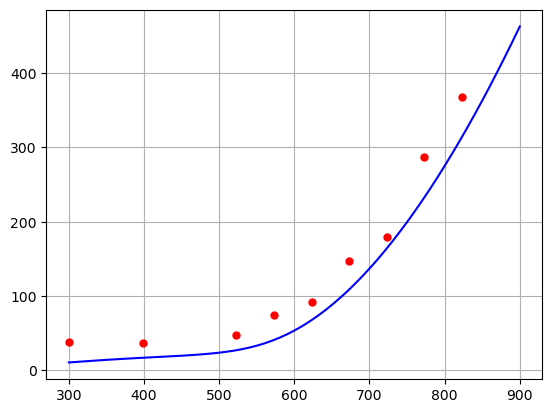

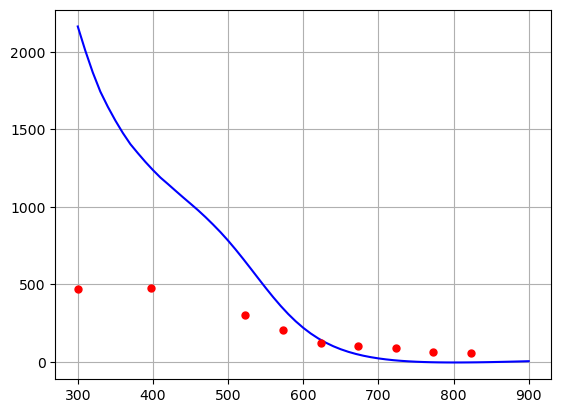

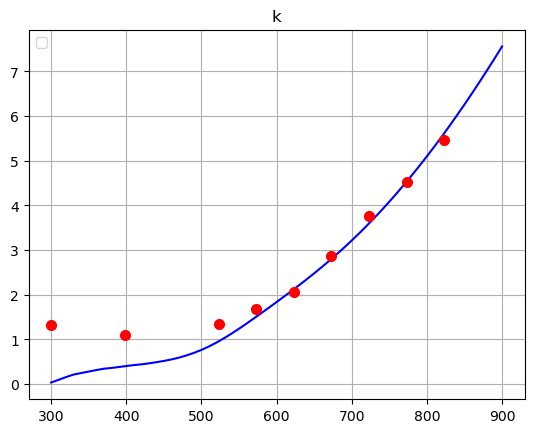

No handles with labels found to put in legend.


In [10]:
figure()
plot(Ts,sigmas[:,1,1]/100,linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn2h5TiO2ECE,linestyle="None",marker=".",markersize=10,color="r")
grid()
figure()
plot(Ts,seebecks[:,1,1]*1e6,linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn2h5TiO2SCS,linestyle="None",marker=".",markersize=10,color="r")
grid()
figure()
title("k")
plot(Ts,klsT[:,1,1]+kes[:,1,1]+kbis[:,1,1],linestyle="-",color="b")
plot(MgSiSn4hKCT .+273,MgSiSn2h5TiO2KCK,linestyle="None",marker="o",markersize=7,color="r")

legend(loc="upper left")
#ylim(1.5,3.5)
grid()

In [11]:
Ts

61-element Array{Float64,1}:
 300.0
 310.0
 320.0
 330.0
 340.0
 350.0
 360.0
 370.0
 380.0
 390.0
 400.0
 410.0
 420.0
   ⋮
 790.0
 800.0
 810.0
 820.0
 830.0
 840.0
 850.0
 860.0
 870.0
 880.0
 890.0
 900.0

In [12]:
foreach(x->println(ks[x,1,1]),1:length(Ts))

0.03670083911859815
0.09636102446941847
0.1590873959752131
0.21418786160485007
0.24814984982433766
0.281499021080225
0.31437429315246873
0.3441389513375254
0.3614297343186592
0.3827374624590507
0.40457580901921114
0.4264131189275641
0.4423293280737404
0.4647562127629585
0.49066814579223417
0.5188673652225914
0.5517842321433606
0.592871274351157
0.6420376488556919
0.6988255084887733
0.765970732960919
0.8434917104844694
0.930719650152322
1.026777642808035
1.1307431208589196
1.2407628060203215
1.3551891525618878
1.4736112476641035
1.5935813831091517
1.7148140261817848
1.8375773684619556
1.9621212536796628
2.0878357233806737
2.2155703740672545
2.346674309009514
2.4809190967767645
2.6186090788287255
2.7604022083676574
2.907585271017271
3.0593118270627913
3.216021388825617
3.37805565341853
3.5464940582791478
3.720111860607359
3.89937313728279
4.084425501315815
4.2761994666060446
4.473295562877346
4.676191348016381
4.885288858172261
5.10033606317832
5.320955509286277
5.547269482780361
5.77971

In [13]:
foreach(x->println(sigmas[x,1,1]),1:length(Ts))

1075.0771975543807
1150.5828740912932
1222.6366528439007
1292.0060097012133
1360.9002240011127
1426.6085851864761
1488.980589003309
1548.5790780887892
1608.1862680640395
1664.2762962158274
1718.0526803222526
1770.301942933412
1824.4473393635428
1877.0161675126722
1930.5203639835595
1987.6895525946995
2049.986485731691
2118.034652188879
2195.1702912915207
2286.675537419002
2394.0346647118113
2521.146811899255
2672.9662092833814
2857.698896768596
3075.95931622305
3333.3338365682584
3634.6587363201998
3989.2460738024984
4392.72816106587
4849.832787325893
5364.971614563059
5940.2822439771935
6571.102653161734
7259.408080812291
8010.1974318562025
8818.380954334276
9681.79901503989
10601.072314124864
11582.647724487582
12616.836750102597
13704.11519747982
14844.825221929652
16046.697600773221
17297.057627971553
18598.592589180975
19951.544531532243
21364.292564275627
22822.446152508623
24330.183780510044
25891.339928437465
27503.236515258326
29161.890213348193
30868.593894887927
32628.116467

In [14]:
foreach(x->println(-seebecks[x,1,1]*1e6),1:length(Ts))

-2164.632179222441
-2009.050231143072
-1867.4703041991509
-1744.3793659358194
-1646.2002906379569
-1557.5242618528005
-1476.9296170721805
-1404.9492035008245
-1346.3253660573941
-1290.0740622031988
-1237.7436843850244
-1189.122023036843
-1147.1937044146666
-1104.28966601322
-1061.8954789887075
-1020.4435065265279
-978.3486207497591
-933.517245313211
-885.948484862681
-835.9836632656009
-782.177137072588
-724.7393252634298
-664.4073669814564
-602.354308938304
-539.3800167365657
-477.1221374380416
-417.07175452694935
-360.37632851325804
-308.147653472516
-260.96197519233084
-218.99737817011618
-182.19182861897735
-150.40135373267785
-123.17316224185157
-99.95999523479665
-80.36140221851059
-63.920330085088494
-50.182429291395614
-38.7072867716938
-29.22955678679217
-21.438284970931726
-15.072111565904494
-9.886763571527654
-5.746090984230767
-2.479636507949179
0.04685941497908109
1.9575702747439554
3.3229984643014454
4.232103364986809
4.7559912195976795
4.949252113441459
4.85959107887409

In [15]:
foreach(x->println(kes[x,1,1]),1:length(Ts))

-1.1860999564255865
-1.1023300122603141
-1.0163941027482786
-0.9390049724087233
-0.8837225755286103
-0.8300704606901733
-0.7779915113797728
-0.7302523536798255
-0.6964844470151353
-0.6603735680497718
-0.6257613389647418
-0.5936371390865032
-0.5708341924943653
-0.5452238600300273
-0.5207974342541279
-0.5000610584816315
-0.4817668370255218
-0.4631302927706456
-0.445502578990044
-0.43136238330473387
-0.4176748057428724
-0.40440844269515624
-0.3921011636936764
-0.3828464295943654
-0.3735225259357705
-0.3648145481349837
-0.3569290958639348
-0.3515198763614601
-0.3457093434934208
-0.3402844456219799
-0.33572377488207705
-0.33192806227456173
-0.3277324170288124
-0.32342585424862014
-0.31960376436903826
-0.3153939822488603
-0.31050854932897987
-0.3050180135844722
-0.29953671282276484
-0.292990615719506
-0.285433118396468
-0.27687869064550696
-0.2679274771794913
-0.2574718398906408
-0.24572642299823166
-0.23268801630408675
-0.2189192909133033
-0.2033546449121939
-0.18628318138973965
-0.16793459

In [16]:
foreach(x->println(kbis[x,1,1]),1:length(Ts))

7.290322425926787e-5
0.00014203274581287334
0.00026247673052665353
0.0004675733795689555
0.0008212209083014096
0.0013920415923987406
0.0022834140951837854
0.003648407084108896
0.005779485446196214
0.008878240196996439
0.01332537510934769
0.01960417995541113
0.028653325777618845
0.04080123253552208
0.05703847814192955
0.07869787130611718
0.10698572766886356
0.1425932989382196
0.18680339195941872
0.24165859834868847
0.3068808747336371
0.38247738953479365
0.46833660171916974
0.5656936364885413
0.6705219811200518
0.781670425945991
0.8977142151179718
1.0199115677668642
1.14295191052026
1.267350621399452
1.3938677554889978
1.5226664969456931
1.6519839736143511
1.7829701711977946
1.9175803832218365
2.054724266408094
2.1944279371216786
2.3374291358115786
2.4856377555918745
2.6371416491298043
2.7924416252539994
2.9519013496596127
3.1172075225080387
3.286034520041643
3.45906747868392
3.636456892909873
3.8197017330327707
4.006342422285731
4.197150842831657
4.392763687416151
4.592728173297268
4.79

In [17]:
foreach(x->println(klsT[x,1,1]),1:length(Ts))

1.2227278923199254
1.1985490039839197
1.175219021992965
1.1527252606340044
1.1310512044446466
1.1101774401779996
1.0900823904370578
1.070742897933242
1.0521346958875983
1.034232790311826
1.0170117728746053
1.0004460780586562
0.9845101947904868
0.9691788402574637
0.9544271019044326
0.9402305523981057
0.9265653415000188
0.9134082681835831
0.9007368358863171
0.8885292934448187
0.8767646639701543
0.865422763644832
0.8544842121268288
0.8439304359138592
0.8337436656746384
0.8239069282093142
0.8144040333078508
0.8052195562586995
0.7963388160823126
0.7877478504043127
0.7794333878550349
0.7713828190085316
0.7635841667951347
0.7560260571180801
0.748697690156716
0.741588812617531
0.7346896910360268
0.7279910861405507
0.7214842282481615
0.715160793652493
0.7090128819680855
0.7030329944044243
0.6972140129506005
0.6915491804563565
0.6860320815971014
0.6806566247100287
0.6754170244865767
0.6703077855038087
0.6653236865744643
0.6604597658927449
0.6557113069505716
0.6510738251971808
0.6465430554135287
